In [ ]:
%pip install scikit-learn
%pip install scikit-image


# **Trabajo: Prototipos de Visión Computacional: Aplicaciones Clásicas**

**Objetivo**:  
Desarrollar una **aplicación práctica** y de industria en el ámbito de la Visión Computacional. Se busca que el resultado sea un prototipo creativo y con potencial de aplicación en el mundo real.


**Fecha de entrega**: 10/04 antes de media noche
**Formato**: Carpeta con scripts, imágenes fuente, resultado y un vídeo corto
de máximo 5 minutos en este repositorio de Github
(https://github.com/adgodoyo/Classic_Computer_Vision)

**Grupo 1**: Sebastián Plazas y Juan Contreras

## Descripción de la tarea
Para este proyecto buscamos desarrollar un modelo de Machine Learning (Sistema de Detección de Anomalías en Ropa), para esto utilizaremos las herramientas aprendidas en clase, puntualmente:
1. **Transformaciones Geométricas y Data Augmentation** -> rotaciones aleatorias
2. **Detección de bordes y umbralización** -> Canny
3. **Ecualización de Histogramas**
4. **Feature Detection y Descriptores (SIFT, SURF)** -> SIFT
5. **Bag of Visual Words (BoVW) o VLAD** -> BoVW
6. **Machine Learning Pipeline en Scikit-Learn** -> Random Forest
7. **Optimización de Hiperparámetros** -> Gridsearch




## Sobre el Dataset
El conjunto de datos fue elaborado por investigadores del **Grupo de Inteligencia Computacional Aplicada (GICAP)** de la **Universidad de Burgos**, en colaboración con **Textil Santanderina**. Contiene imágenes originales y procesadas de tejidos entrelazados **Batavia** y **Sarga**, capturadas con una cámara Basler de alta resolución bajo condiciones de iluminación infrarroja controladas. Está diseñado para entrenar modelos de inteligencia artificial enfocados en la **detección de defectos textiles** y la **evaluación de calidad**. Incluye imágenes originales de **2048x696 píxeles** y sus correspondientes parches de **365x365 píxeles**, clasificados como defectuosos (Cases) o no defectuosos (Control), junto con un archivo CSV con anotaciones expertas y etiquetas de operadores. Fue publicado en **enero de 2025** como parte del proyecto **DECENT**, financiado por la iniciativa **DIH-World**.

Contacto principal: [Beatriz Gil Arroyo](mailto:bgarroyo@ubu.es)  
ORCID de los autores:  
- [Beatriz Gil Arroyo](https://orcid.org/0009-0009-8499-093X)  
- [Nuria Velasco-Pérez](https://orcid.org/0009-0008-2988-757X)  
- [Nuño Basurto](https://orcid.org/0000-0001-7289-4689)  
- [Juan Marcos Sanz](https://orcid.org/0000-0002-2024-9909)  
- [Ángel Arroyo](https://orcid.org/0000-0002-1614-9075)  
- [Daniel Urda](https://orcid.org/0000-0003-2662-798X)  
- [Álvaro Herrero](https://orcid.org/0000-0002-2444-5384)

link al articulo: (https://www.sciencedirect.com/science/article/pii/S2352340925001830)


## Codigo:

### Importamos Librerías

In [84]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler


# para medir cuanto tiempo se demora ejecutando el código
import time
start_time = time.time()

### Cargamos las imágenes del dataset 

En especifico estamos usando las Imágenes "Parches" del dataset de **Sarga**  esto ya que aunque tiene una cantidad de datos desbalanceado las carácteristicas de la ropa Anómala son mucho mejores, lo que la hace idea a pesar de este desbalance, teniendo imagenes de 365x365 píxeles clasificados en ropa normal y ropa anormal (ya sea por huecos, dobleces o defectos de costura)

 tamaño normal: 18401
 tamaño anómala: 173


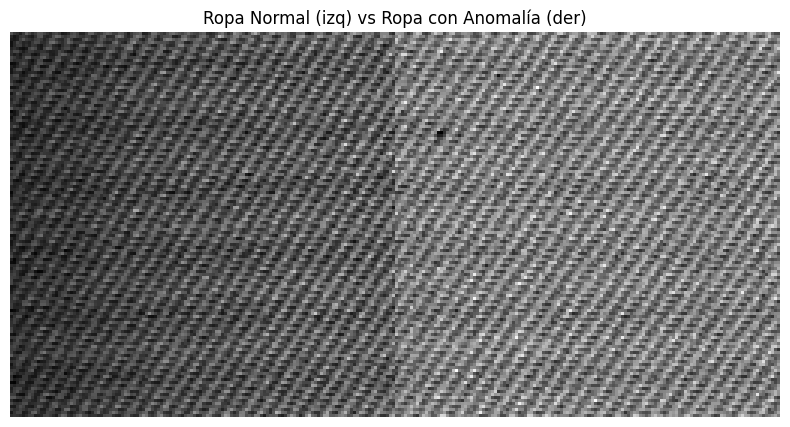

In [85]:
# =====================
# 2. Cargar imágenes y etiquetas
# =====================
def cargar_imagenes(path, etiqueta, size=(128,128)):
    X, y = [], []
    for archivo in os.listdir(path):
        img = cv2.imread(os.path.join(path, archivo), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, size)
            X.append(img)
            y.append(etiqueta)
    return X, y

ropa_normal, y_normal = cargar_imagenes("./controls", 0)
ropa_anomalia, y_anomalia = cargar_imagenes("./cases", 1)
 
print(f" tamaño normal: {len(ropa_normal)}")
print(f" tamaño anómala: {len(ropa_anomalia)}")


## visualizamos una imagen de cada dataset
comparacion = np.hstack((ropa_normal[0], ropa_anomalia[16]))

# Mostramos la comparación
plt.figure(figsize=(10, 5))
plt.imshow(comparacion, cmap='gray')
plt.title("Ropa Normal (izq) vs Ropa con Anomalía (der)")
plt.axis("off")
plt.show()


note que tenemos muy poca imágenes de ropa defectuosa por lo que hacemos un aumento de datos (note que tenemos especial cuidado con al hacerle las transformaciones no se pierda la anomalía): 



In [ ]:
# Data augmentaion -> para las de categoría 1(ropa anomala)

def augmentar_imagen(img):
    filas, cols = img.shape[:2]
    img_aug = img.copy()

    # Rotación aleatoria (±15°)
    if np.random.rand() > 0.5:
        M_rot = cv2.getRotationMatrix2D((cols / 2, filas / 2), np.random.uniform(-15, 15), 1)
        img_aug = cv2.warpAffine(img_aug, M_rot, (cols, filas), borderMode=cv2.BORDER_REFLECT)

    # Traslación aleatoria (±5 píxeles)
    if np.random.rand() > 0.5:
        dx, dy = np.random.randint(-5, 6, 2)
        M_trans = np.float32([[1, 0, dx], [0, 1, dy]])
        img_aug = cv2.warpAffine(img_aug, M_trans, (cols, filas), borderMode=cv2.BORDER_REFLECT)

    # Flip horizontal aleatorio
    if np.random.rand() > 0.5:
        img_aug = cv2.flip(img_aug, 1)

    # Flip vertical aleatorio
    if np.random.rand() > 0.5:
        img_aug = cv2.flip(img_aug, 0)

    return img_aug


# Duplicar imágenes anómalas con aumentaciones suaves
ropa_anomalia_aug = []
for img in ropa_anomalia:
    for _ in range(10):  # Duplicamos anomalías
        ropa_anomalia_aug.append(augmentar_imagen(img))

y_anomalia_aug = [1] * len(ropa_anomalia_aug)

print(f" tamaño normal: {len(ropa_normal)}")
print(f" tamaño anómala: {len(ropa_anomalia)+ len(ropa_anomalia_aug)}")


# Reunimos todo el dataset balanceado
X = ropa_normal + ropa_anomalia + ropa_anomalia_aug
y = y_normal + y_anomalia + y_anomalia_aug





 tamaño normal: 18401
 tamaño anómala: 1903


Podemos ver que no logramos generar una cantidad de data igual pero al aumentar nos arriesgamos a sobre-entrenar el modelo

## Preprocesar la Imagen
Debido a que las imágenes no tienen una diferencia que el ojo humano pueda detectar tan facilmente y ser de alta resolución, utilizaremos la **equalizacion del histograma** para aumentar la saturación y la **detección de bordes** con canny para resaltar esa "Textura" de la ropa permitiendonos encontrar en que punto esa "Textura" no es simetrica y detectando las anomalías mejor.

In [ ]:
# 1. Funciones de preprocesamiento
def solo_ecualizacion(img):
    imf=  cv2.equalizeHist(img)
    # Aplicamos suavizado previo para reducir ruido
    img_blur = cv2.GaussianBlur(img, (3, 3), 0)
    # Aplicamos Canny con umbrales bajos
    edges = cv2.Canny(img_blur, threshold1=30, threshold2=60)

    return edges

# # 2. Aplicar ambos preprocesamientos
X_proc_eq = [solo_ecualizacion(img) for img in X]

## Aplicación de SIFT y creación de BoVW

Utilizaremos SIFT para detectar esas caracteristicas de cada imagen, Kmeans para generar un "Vocabulario visual" todo esto para la creación de un BoVW

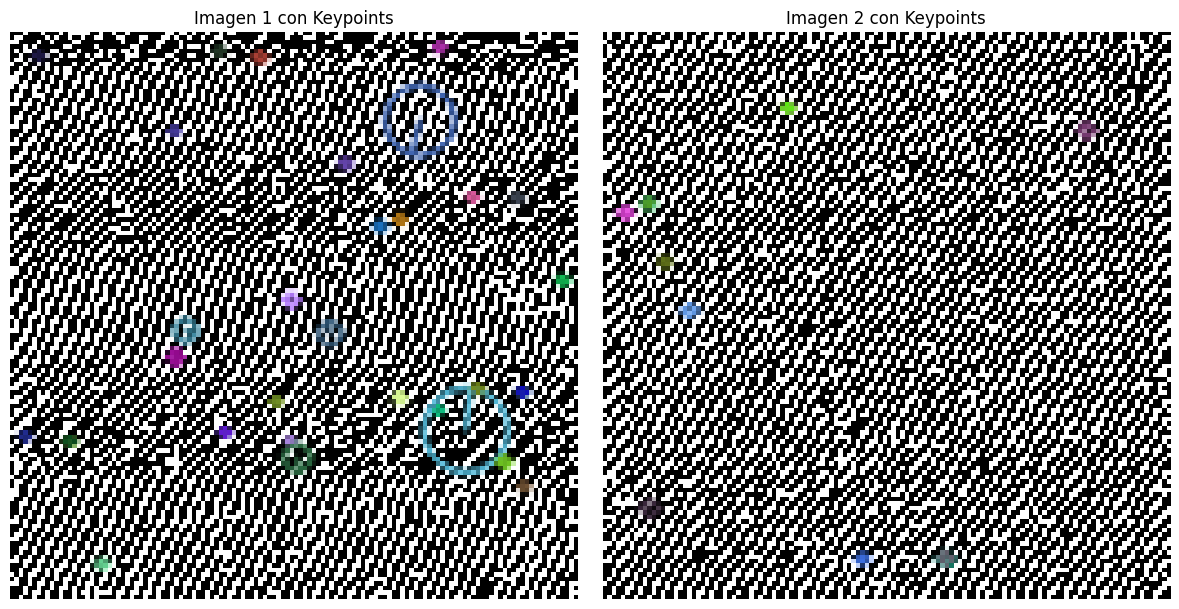

In [ ]:
# =====================
# 4. Extracción de características (SIFT + BoVW)
# =====================

#Detección de las caracteristicas usando SIFT
sift = cv2.SIFT_create()
all_descriptors = []
for img in X_proc_eq:
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
        all_descriptors.extend(des.astype(np.float32))

#Creación del vocabulario visual
all_descriptors = np.array(all_descriptors, dtype=np.float32)
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(all_descriptors)

#creación del histograma de frecuencias (BoVW)
def construir_histograma(img):
    kp, des = sift.detectAndCompute(img, None)
    hist = np.zeros(50)
    if des is not None:
        des = des.astype(np.float32)
        pred = kmeans.predict(des)
        for p in pred:
            hist[p] += 1
    return hist

X_features = np.array([construir_histograma(img) for img in X_proc_eq])

## visualizamos la detección de caracteristicas en dos imágenes de X_proc
imgs = [X_proc_eq[16], X_proc_eq[18]]

# Dibuja keypoints para ambas
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, img in enumerate(imgs):
    kp = sift.detect(img, None)
    img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axs[i].imshow(img_kp, cmap='gray')
    axs[i].set_title(f'Imagen {i+1} con Keypoints')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Machine learning
usamos nuestra BoVW (X_features) para entrenar un modelo de Machine learning con los siguientes pasos:
* Transformaciones de datos -> realizado en pasos anteriores
* Selección de características -> realizado en pasos anteriores
* Entrenamiento de clasificador (Random Forest)
* Evaluación y Métricas.

Note que usamos `RandomForestClassifier`  ya que es una **elección sólida** para un pipeline con BoVW porque:

- Se adapta naturalmente al tipo de datos generados.
- Tiene buen desempeño sin necesidad de ajustes complicados.
- Es estable, rápido y fácil de interpretar.


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3669
           1       0.98      0.51      0.67       392

    accuracy                           0.95      4061
   macro avg       0.96      0.76      0.82      4061
weighted avg       0.95      0.95      0.94      4061

Matriz de confusión:
 [[3664    5]
 [ 191  201]]


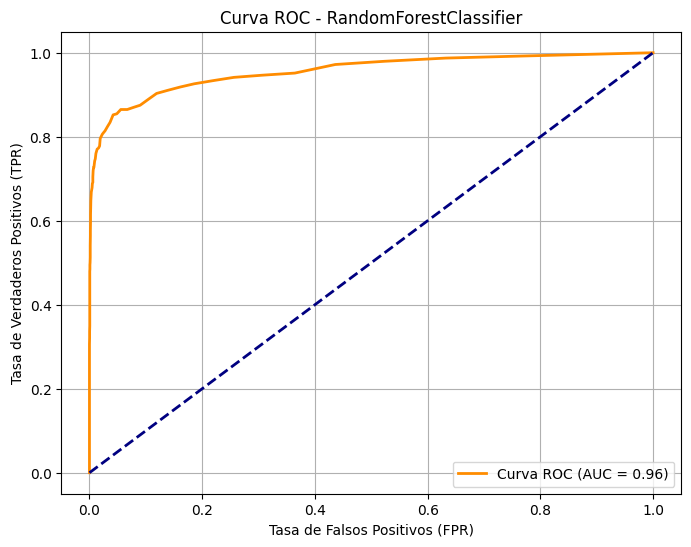

In [90]:
# =====================
# 5. Pipeline con RandomForest normal
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42, class_weight='balanced')) 
])

pipe.fit(X_train, y_train)

# =====================
# 6. Resultados
# =====================
y_pred = pipe.predict(X_test)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))




# Obtener probabilidades de clase positiva
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1 (anómala)

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - RandomForestClassifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Mejorando hiperparametros

Obtuvimos muy buenas métricas en el resultado por defecto, pero podemos mejorarlo?
Para esto utilizaremos GridSearch para encontrar los mejores hiperparametros de nuestro modelo

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Mejores parámetros: {'clf__max_depth': 30, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 150}
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3669
           1       0.90      0.72      0.80       392

    accuracy                           0.97      4061
   macro avg       0.94      0.85      0.89      4061
weighted avg       0.96      0.97      0.96      4061

Matriz de confusión:
 [[3638   31]
 [ 111  281]]


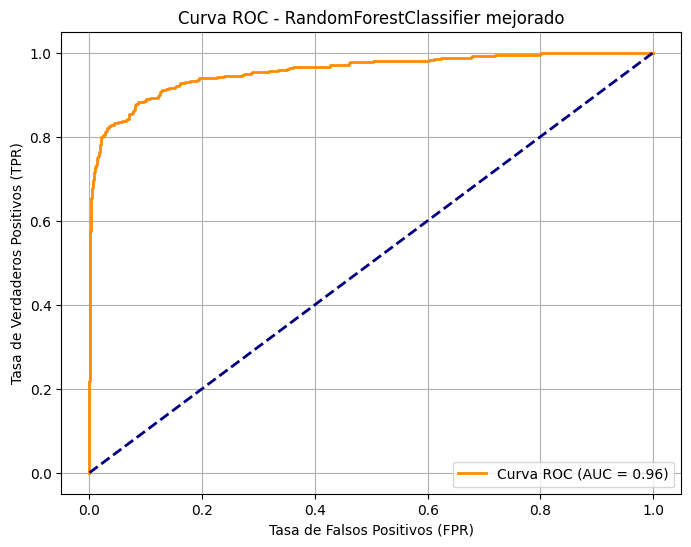

In [91]:
# =====================
# 5. Pipeline con RandomForest y GridSearch (ampliado)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    "clf__n_estimators": [50, 100, 150, 200],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# =====================
# 6. Resultados y curva ROC
# =====================
y_pred = grid.predict(X_test)



print("Mejores parámetros:", grid.best_params_)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))




# Obtener probabilidades de clase positiva
y_prob = grid.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1 (anómala)

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - RandomForestClassifier mejorado')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [92]:


# =====================
# 7. Metricas del notebook
# =====================

end_time = time.time()
total_time = end_time - start_time

mins, secs = divmod(total_time, 60)
print(f"⏱️ Tiempo total de ejecución: {int(mins)} minutos y {secs:.2f} segundos")

⏱️ Tiempo total de ejecución: 4 minutos y 35.63 segundos


## Resultados del modelo mejorado

### Métricas generales
- **Accuracy**: 0.97  
- **AUC ROC**: 0.96 → excelente capacidad discriminativa

### Desempeño por clase
- **Clase 0 (normal)**  
  - Precisión: 0.97  
  - Recall: 0.99  
  - F1-score: 0.98

- **Clase 1 (anómala)**  
  - Precisión: 0.90  
  - Recall: 0.72  
  - F1-score: 0.80

### Promedios
- **Macro avg (no ponderado)**: F1 ≈ 0.89  
- **Weighted avg**: F1 ≈ 0.89

---

## 📌 Conclusiones

Es un buen modelo para la detección de anomalías en ropa , lo podemos ver atravez de su Recall y de su disinución de los Falsos Negativos, aunque esto tambien puede deberse a sobre-entrenamiento


1. **Aumento de datos exitoso**: El aumento de datos aplicado a la clase minoritaria (ropa anómala) mejoró significativamente su desempeño.
2. **Problema principal**: Aunque el recall de la clase 1 mejoró, sigue siendo menor que el de la clase 0. 
3. **Posibles mejoras**:
   - **Probar aumento de datos también para la clase normal** para verificar consistencia.
   - **Evaluar modelos CNN** que podrían ofrecer un mejor desempeño, aunque más costosos.
   - **Analizar falsos positivos y negativos** para mejorar aún más la precisión y recall en la clase 1.